# Neural Network Prediction of Sahelian Summer Rainfall
***

#### Resources:
* [Mardata Course](https://github.com/mardatade/Course-Python-for-Machine-Learning/blob/master/3.%20Neural%20Network.ipynb)
* [Keras for Data Scientists](https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing)

In [12]:
import numpy as np
import pandas as pd 
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as st

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers

<br>
<br>

## 1. Data Loading & Preprocessing
***

<br>

### a) Loading & Normalization

**pred:** contains the data used for the inputs  <br>
**label:** from Sahelrainfall data serves as validation data

In [13]:
pred = xr.open_dataset('da_pred_all.nc').to_dataframe()

pred_unit = pd.DataFrame(
    data = StandardScaler().fit_transform(pred), 
    columns = pred.columns,
    index =  pred.index
)


# load validatoin data (Summer Rainfall over Sahel) 
labels = np.mean(np.loadtxt("da_o_sahelprecip19012017.txt", skiprows=8,)[:,7:10] * 0.01,  axis=1)


In [14]:
pred_unit.head()

,siod_e,siod_w,sst_med,tsa,tna,sst_mdr,sata_lnh,sata_lsh,sata_onh,sata_osh,slp_darwin,slp_tahiti,amo,nao,pdo,np,nino12,nino3,nino34,nino4
year,,,,,,,,,,,,,,,,,,,,
1901,-1.100027,-1.152764,-0.745530,-0.595366,0.388372,0.608415,-0.123443,-0.732091,-0.497808,-0.737797,0.074807,1.634819,0.923204,0.917456,-0.193321,1.938388,-0.950168,-0.595561,-0.214314,-0.079270
1902,0.088643,0.340415,-1.507314,-0.954566,-0.346586,-0.173588,-1.289978,-0.201810,-1.175314,-0.987096,1.443896,2.682485,-0.620146,-1.172590,0.819716,-0.162154,0.991321,0.969845,1.099218,1.070532
1903,-0.900789,0.669332,-2.243639,-2.186294,-0.101970,0.283583,-1.333183,-1.076056,-1.415719,-1.333946,-0.071881,1.535042,-0.458290,-1.030410,-0.186187,0.530864,-0.371251,0.000784,0.524139,0.842095
1904,-0.949568,-1.056219,-0.079925,-1.975498,-2.214111,-1.894743,-1.135674,-1.133384,-1.863746,-1.778347,-0.903114,1.235708,-1.872482,1.447076,-0.892459,0.756497,-0.307712,-0.234313,-0.475713,-0.741738
1905,-0.034350,-0.632249,-0.718895,-1.684676,-1.334312,-1.014906,-1.314666,-0.595938,-1.284589,-0.954579,0.759351,-2.655622,-0.499163,-1.289888,0.545055,-0.326007,1.227830,1.497381,1.439037,1.032459


<br>

### b) PCA

### **Question:** normalize pcs again? --> See : [Data loading & preprocessing](https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing) 
variance is non-unit for now...\
or does another normalization clear out the information of the pcs?
Badr did not mention anything like that.

In [15]:
# Scikit pca transformation
pca = PCA()
principalComponents = pca.fit_transform(pred_unit)


# Create Create Pandas DF from PCs
col = []
for i in range(1, 21):
    col.append(f'PC{i}')

pred_pc = pd.DataFrame(
    data = principalComponents,
    columns = col,
    index =  pred.index
)

# Test for unit-variance and zero mean:
# np.std(pred_pc)
# np.mean(pred_pc)
# pred_pc.head()

<br>

### c) Select PCs for input and turn into numpy array

In [16]:
features = pred_pc.loc[:,['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC13']].to_numpy()
features.shape

(117, 9)

<br>
<br>

## 2. Build Model
***

### **Question:** Badr says in Table2: '**standard* correlation and error meassures'? --> means standard or standardized?

<br>

## a) RRHCV


### 1.) Define Model

 * Set Layers -> units, activation function, weight decay **note: I just read the reg. below l2 != weight decay**
 * Set loss function and ptimizer + learning rate

In [17]:
def Buildmodel():        
    model = keras.Sequential(
        [
            layers.Dense(3, activation="sigmoid", kernel_regularizer=regularizers.l2(1e-2) ,name="layer1", input_shape=(9,)),
            layers.Dense(1, activation='linear', name='output') # weight decay for all
        ]
    )
    
    opt = keras.optimizers.SGD(learning_rate=0.01)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

<br>

### 2.) Train model
* Perfrom in total k Repetitions
* For each walkthrough the data is first shuffled and the split into training (90%) and test (10%) sets.
* save single error metrics () into numpy array 
* **set parameters at top of cell**

In [18]:
### choose parameters ###

k = 5 # number of 'folds' -> sample size as in Badr
test_frac = .1 # factrion that is held out for testing
#model training
bs= 1 # batch_size
n_epochs = 150 # numer of epochs


# define error metrics:
mae_train = []
mad_train = []
mse_train = []
rmse_train = []
corr_train = []

mae_test = []
mad_test = []
mse_test = []
rmse_test = []
corr_test = []


# use sklearn Shuffle Split to Lood through Cross-Validation
for train_index, test_index in ShuffleSplit(n_splits=k, test_size=test_frac).split(features):
    
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    # Build the model according to definition:
    model = Buildmodel()
    
    #Train the model 
    model.fit(features[train_index], labels[train_index], batch_size=bs , epochs=n_epochs, verbose=0)
    
    #Run the model for insample data:
    y_train= np.squeeze(model.predict(features[train_index]))
    
    # ... and for out of sample data
    y_test = np.squeeze(model.predict(features[test_index]))
    
    
    # save errors into numpy arrays:
    e_train =  y_train - labels[train_index]
    ae_train = np.absolute(e_train)
    mae_train = np.append(mae_train, np.mean(ae_train))
    mad_train = np.append(mad_train, np.median(np.absolute(e_train - np.median(e_train))))
    mse_train = np.append(mse_train, np.mean(e_train**2))
    rmse_train = np.append(rmse_train, np.sqrt(mse_train))
    corr_train = np.append(corr_train, st.pearsonr(y_train, labels[train_index])[0])
    
    
    e_test =  y_test - labels[test_index]
    ae_test = np.absolute(e_test)
    mae_test = np.append(mae_test, np.mean(ae_test))
    mad_test = np.append(mad_test, np.median(np.absolute(e_test - np.median(e_test))))
    mse_test = np.append(mse_test, np.mean(e_test**2))
    rmse_test = np.append(rmse_test, np.sqrt(mse_test))
    corr_test = np.append(corr_test, st.pearsonr(y_test, labels[test_index])[0])



<br>

### 3.) Error Computation

#### Training Errors

In [20]:
train_errors = pd.DataFrame(
    data = {
        'corr_mu': [np.mean(corr_train)],
        'corr_sig': [np.std(corr_train)],
        'mad_mu': [np.mean(mad_train)],
        'mad_sig': [np.std(mad_train)],
        'mae_mu': [np.mean(mae_train)],
        'mae_sig': [np.std(mae_train)],
        'mse_mu': [np.mean(mse_train)],
        'mse_sig': [np.std(mse_train)],
        'rmse_mu': [np.mean(rmse_train)],
        'rmse_sig': [np.std(rmse_train)],
    }
)
train_errors

,corr_mu,corr_sig,mad_mu,mad_sig,mae_mu,mae_sig,mse_mu,mse_sig,rmse_mu,rmse_sig
0,0.786725,0.011336,0.699318,0.030898,0.922617,0.012621,1.501067,0.102258,1.234843,0.043883


<br>

#### Test Errors

In [21]:
test_errors = pd.DataFrame(
    data = {
        'corr_mu': [np.mean(corr_test)],
        'corr_sig': [np.std(corr_test)],
        'mad_mu': [np.mean(mad_test)],
        'mad_sig': [np.std(mad_test)],
        'mae_mu': [np.mean(mae_test)],
        'mae_sig': [np.std(mae_test)],
        'mse_mu': [np.mean(mse_test)],
        'mse_sig': [np.std(mse_test)],
        'rmse_mu': [np.mean(rmse_test)],
        'rmse_sig': [np.std(rmse_test)],
    }
)
test_errors

,corr_mu,corr_sig,mad_mu,mad_sig,mae_mu,mae_sig,mse_mu,mse_sig,rmse_mu,rmse_sig
0,0.553251,0.23696,1.0432,0.254653,1.302874,0.314222,3.108806,1.504158,1.651161,0.422858


<br>

### 4.) PLot model output vs Validation Data

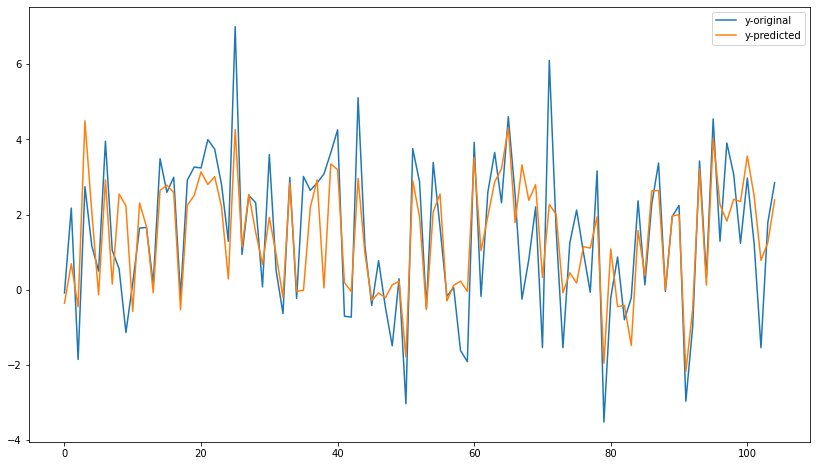

In [22]:
plt.figure(figsize=(14,8))
plt.plot(labels[train_index], label="y-original")
plt.plot(y_train, label="y-predicted")
plt.legend()
plt.show()

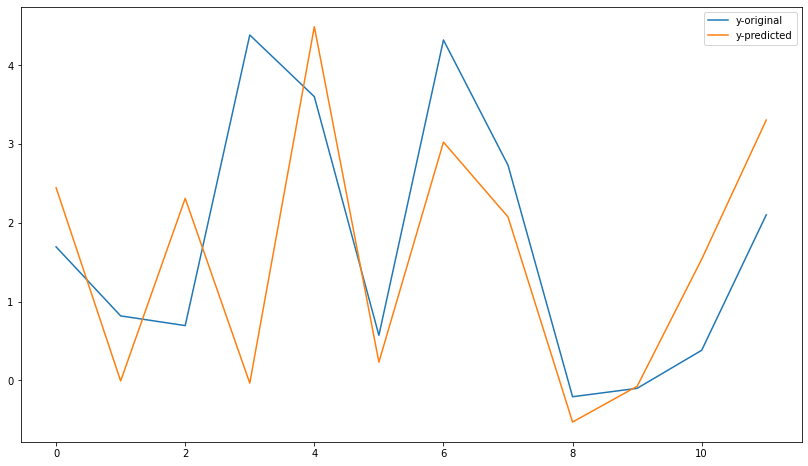

In [23]:
plt.figure(figsize=(14,8))
plt.plot(labels[test_index], label="y-original")
plt.plot(y_test, label="y-predicted")
plt.legend()
plt.show()

stopped attempt of funcitonaizing error computation

In [24]:
dict =	{
    "mae_train": [],
    'mad_train': [],
    'mse_train': [],
    'rmse_train': [],
    'corr_train': []
}


dict['mae_train'] = np.append (dict['mae_train'], 1)

def errors (string):
    
    dict[f'mae_{string}'] = np.append (dict[f'mae_{string}'], np.mean(ae_test))
    dict[f'mad_{string}'] = np.append(f'mad_{string}', np.median(np.absolute(e_train - np.median(e_train))))
    dict[f'mse_{string}'] = np.append(f'mse_{string}', np.mean(e_train**2))
    dict[f'rmse_{string}'] = np.append(f'rmse_{string}', np.sqrt(mse_train))
    dict[f'corr_{string}'] = np.append(f'corr_{string}', st.pearsonr(y_train, labels[train_index])[0])
